In [1]:
import numpy as np
import torch
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import config as c



xi = np.load('./data/model1D.npy')
yi = np.load('./data/phase.npy')


c.ub = np.array([0.63, 0.79, 0.88, 0.95, 1.05, 1.2 , 1.28, 1.36, 1.36, 1.4 ])
c.lb = np.array([0.33, 0.43, 0.48, 0.51, 0.55, 0.6 , 0.58, 0.56, 0.56, 0.6 ])

xi = 4*(xi-(c.ub+c.lb)/2)/(c.ub-c.lb)

train_size = 100000
test_size = 10000

x_train = torch.Tensor(xi[:train_size,:])
y_train = torch.Tensor(yi[:train_size,:])
x_test = torch.Tensor(xi[-test_size:,:])
y_test = torch.Tensor(yi[-test_size:,:])

#--------basic setting------
c.filename_out = './models/INNs_1D.pt'
c.device = 'cuda:0'

#--------Adam setting-------
c.lr_init         = 1e-3
c.final_decay = 0.01
c.batch_size = 500
c.n_its_per_epoch = 20
c.n_epochs = 1000
c.pre_low_lr = 0

#-------model setting-------
c.ndim_x = 10
c.ndim_pad_x = 12
c.ndim_y = 14
c.ndim_z = 22
c.ndim_pad_zy = 0

c.add_pad_noise = 1e-2
c.add_y_noise = 1e-2
c.hidden_layer_sizes = 512
c.cnn_layer_sizes = 32
c.use_permutation = True
c.interactive_visualization = False
c.init_scale = 0.001
c.N_blocks=4 

##-------loss setting---------
c.interactive_visualization = False
c.show_test_loss = True
c.show_total_loss = False

c.train_max_likelihood = True
c.train_forward_fit       = True
c.train_independence_loss = True


c.lambd_max_likelihood = 0.1
c.lambd_fit_forw       = 10
c.lambd_independence_loss    = 0.1



c.train_loader = torch.utils.data.DataLoader(TensorDataset(x_train,y_train[:,None]),batch_size=c.batch_size,shuffle=True,drop_last=True)
c.test_loader = torch.utils.data.DataLoader(TensorDataset(x_test,y_test[:,None]),batch_size=c.batch_size,shuffle=False,drop_last=True)

print('all done before train')

all done before train


In [ ]:
import os
import model

train.main()

## Test

In [2]:
import torch.nn as nn
from FrEIA.framework import *
from FrEIA.modules import *

########################### Load Pre-trained Model ###########################
nodes = [InputNode(c.ndim_x + c.ndim_y + c.ndim_pad_x, name='input')]

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, c.hidden_layer_sizes), nn.ReLU(),
                         nn.Linear(c.hidden_layer_sizes,  c_out))

for i in range(c.N_blocks):
    nodes.append(Node(nodes[-1].out0,
                  GLOWCouplingBlock,
                  {'subnet_constructor':subnet_fc, 'clamp':c.exponent_clamping},
                  name='coupling_{}'.format(i)))
    
    if c.use_permutation:
        nodes.append(Node(nodes[-1].out0,
                      PermuteRandom,
                      {'seed':i}, name='permute_{}'.format(i)))

nodes.append(OutputNode([nodes[-1].out0], name='output'))

INN = ReversibleGraphNet(nodes, verbose=c.verbose_construction)
INN.to(c.device)

state_dicts = torch.load(c.filename_out)
INN.load_state_dict(state_dicts['net'])

<All keys matched successfully>

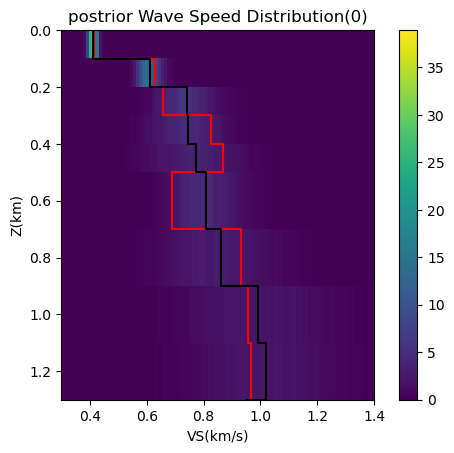

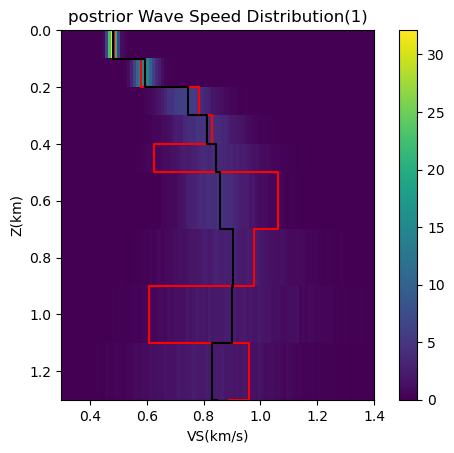

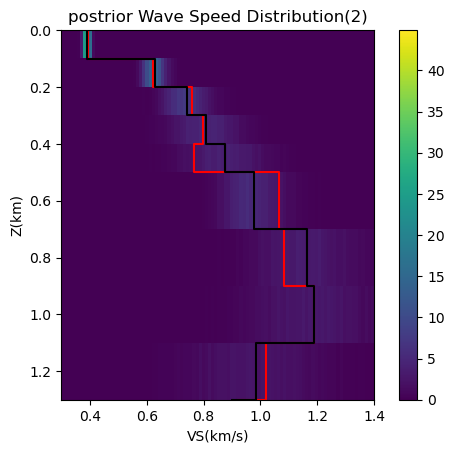

In [5]:
N_test=5000 

for k in range(3):

##---------------------inverse--------------------------
    x_sample = x_test[k].cpu().numpy()

    y_sample  = y_test[k].cpu().numpy()

    x_sample = np.tile(x_sample , (N_test, 1))
    y_sample = np.tile(y_sample , (N_test, 1))
    x_sample =torch.Tensor(x_sample ).to(c.device)
    y_sample =torch.Tensor(y_sample ).to(c.device)

    def noise_batch(N, ndim):
        return torch.randn(N, ndim).to(c.device)

    noise_test = c.add_y_noise * noise_batch(N_test, c.ndim_y)

    if c.add_y_noise > 0:
        y_sample  += noise_test

    if c.ndim_pad_zy:
        y_sample  = torch.cat((c.add_pad_noise * noise_batch(N_test, c.ndim_pad_zy), y_sample), dim=1)
    y_sample  = torch.cat((noise_batch(N_test, c.ndim_z), y_sample), dim=1)

    x_noise_pred = INN(y_sample , rev=True)[0]
    x_pred = x_noise_pred[:, 0:c.ndim_x]

    ##---------------------plot--------------------------

    x_sampled =  x_pred.cpu().detach().numpy()*(c.ub-c.lb)/4 +(c.ub+c.lb)/2
    x_sampled_average=np.mean(x_sampled, axis=0)
    x_true = x_test[k].cpu().numpy()*(c.ub-c.lb)/4 +(c.ub+c.lb)/2

    bin_widths = np.array([0.1] * 5 + [0.2] * 4)
    bin_edges = np.concatenate(([0], np.cumsum(bin_widths)))

    depths = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3])

    x_sampled_extended = np.hstack((
        x_sampled[:, :5],  
        np.repeat(x_sampled[:, 5:], 2, axis=1)  
    ))

    depths_extended = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])


    bins = 100

    H = np.zeros((len(depths_extended) - 1, bins))  # 50个bins

    for i in range(len(depths_extended) - 1):
        hist, _ = np.histogram(x_sampled_extended[:, i], bins=bins, range=(0.3, 1.4), density=True)
        H[i, :] = hist

    # 设置绘图
    fig, ax = plt.subplots()



    extent = [0.3, 1.4, depths_extended[0], depths_extended[-1]]
    im = ax.imshow(H, aspect='equal', extent=extent, interpolation='nearest', origin='lower')


    # ax.plot(sample_wave_speeds, depths, marker='o', color='red', label='Sample Wave Speed')
    ax.step(x_true, depths, where='pre', color='red', label='Sample Wave Speed')

    ax.step(x_sampled_average, depths, where='pre', color='black', label='Sample Wave Speed')

    ax.set_ylim(ax.get_ylim()[::-1])

    # 设置轴标签和图表标题
    ax.set_xlabel('VS(km/s)')
    ax.set_ylabel('Z(km)')
    ax.set_title(f'postrior Wave Speed Distribution({k})')

    # 显示颜色条
    plt.colorbar(im, ax=ax)

    plt.show()
